<a href="https://colab.research.google.com/github/deshaami/Dog-Breed-Classification-Using-InceptionResNetV2/blob/main/InceptionResNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/AI_Lab

/content/drive/MyDrive/AI_Lab


In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/AI_Lab/dog_dataset.zip', 'r') as zip_ref:
            zip_ref.extractall('/content/drive/MyDrive/AI_Lab/')

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

# deep learning libraries
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image

import cv2

import warnings
warnings.filterwarnings('ignore')


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

# datasets
labels = pd.read_csv("/content/drive/MyDrive/AI_Lab/dog_dataset/labels_new.csv")
#sample = pd.read_csv('/content/drive/My Drive/dog/sample_submission.csv')

# folders paths
train_path = "/content/drive/MyDrive/AI_Lab/dog_dataset/train"
test_path = "/content/drive/MyDrive/AI_Lab/dog_dataset/test"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
labels.head()


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
def to_jpg(id):
    return id+".jpg"


labels['id'] = labels['id'].apply(to_jpg)
#sample['id'] = sample['id'].apply(to_jpg)


In [ ]:
# Data agumentation and pre-processing using tensorflow
gen = ImageDataGenerator(
                  rescale=1./255.,
                  horizontal_flip = True,
                  validation_split=0.2 # training: 80% data, validation: 20% data
                 )

train_generator = gen.flow_from_dataframe(
    labels, # dataframe
    directory = train_path, # images data path / folder in which images are there
    x_col = 'id',
    y_col = 'breed',
    subset="training",
    color_mode="rgb",
    target_size = (331,331), # image height , image width
    class_mode="categorical",
    batch_size=64,
    shuffle=True,
    seed=42,
)


validation_generator = gen.flow_from_dataframe(
    labels, # dataframe
    directory = train_path, # images data path / folder in which images are there
    x_col = 'id',
    y_col = 'breed',
    subset="validation",
    color_mode="rgb",
    target_size = (331,331), # image height , image width
    class_mode="categorical",
    batch_size=64,
    shuffle=True,
    seed=42,
)


Found 768 validated image filenames belonging to 120 classes.
Found 192 validated image filenames belonging to 120 classes.


In [ ]:
x,y = next(train_generator)
x.shape # input shape of one record is (331,331,3) , 32: is the batch size


(64, 331, 331, 3)

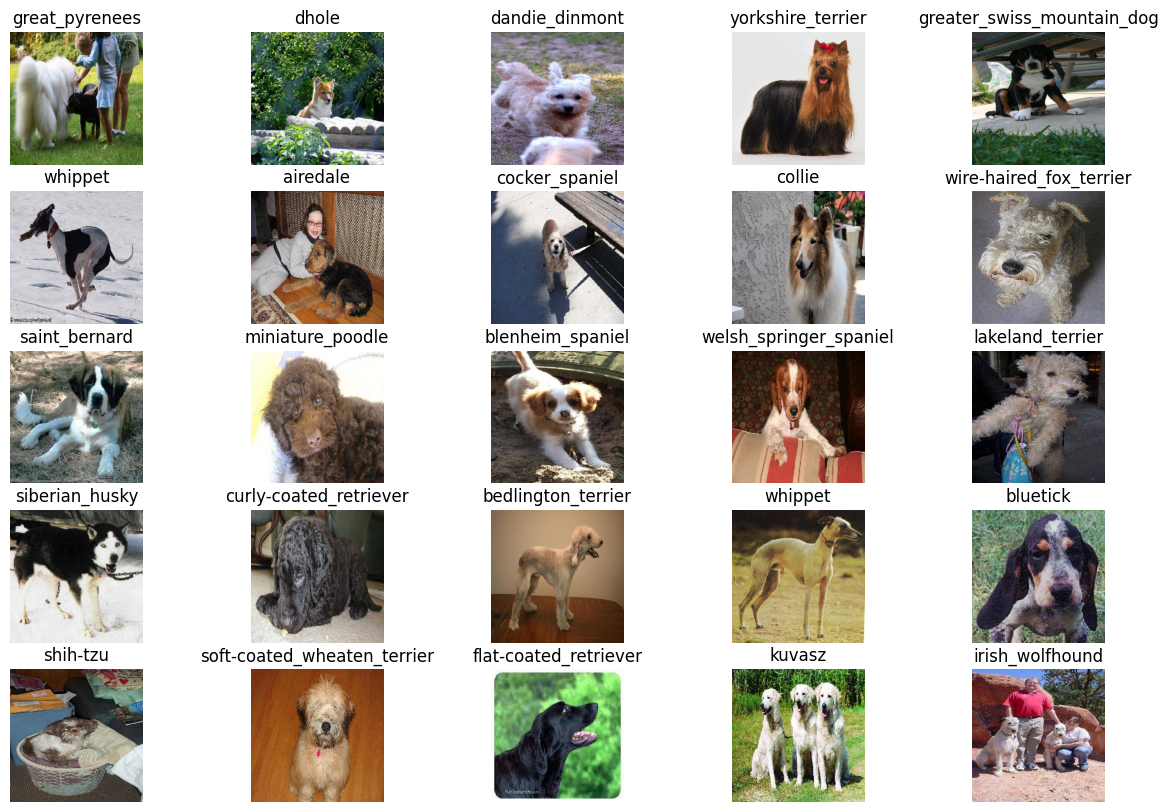

In [ ]:
a = train_generator.class_indices
class_names = list(a.keys())  # storing class/breed names in a list


def plot_images(img, labels):
    plt.figure(figsize=[15, 10])
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')

plot_images(x,y) # removed extra indentation from this line

In [ ]:
# load the InceptionResNetV2 architecture with imagenet weights as base
base_model = tf.keras.applications.InceptionResNetV2(
                     include_top=False,
                     weights='imagenet',
                     input_shape=(331,331,3)
                     )

base_model.trainable=False

# Build the model and pass an input with a defined shape
# so the model can infer the shapes of all the layers
input_tensor = tf.keras.Input(shape=(331,331,3))
output_tensor = base_model(input_tensor)

# Now build the rest of the model
model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(120, activation='softmax')
    ])

# This code is modified by Susobhan Akhuli


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


In [ ]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# categorical cross entropy is taken since its used as a loss function for
# multi-class classification problems where there are two or more output labels.
# using Adam optimizer for better performance
# other optimizers such as sgd can also be used depending upon the model


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_resnet_v2 (Functional)     │ (None, 9, 9, 1536)          │      54,336,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_203              │ (None, 1536)                │           6,144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         786,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 120)                 │          15,480 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 55,309,528 (210.99 MB)

 Trainable params: 969,720 (3.70 MB)

 Non-trainable params: 54,339,808 (207.29 MB)

In [ ]:
early = tf.keras.callbacks.EarlyStopping( patience=10,
                                          min_delta=0.001,
                                          restore_best_weights=True)
# early stopping call back


In [ ]:
batch_size=64
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

# fit model
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=25,
                    callbacks=[early])

# This code is modified by Susobhan Akhuli


Epoch 1/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.4979 - loss: 2.5008 - val_accuracy: 0.5417 - val_loss: 3.8894
Epoch 2/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7724 - loss: 1.0663 - val_accuracy: 0.7448 - val_loss: 3.2714
Epoch 3/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 974ms/step - accuracy: 0.8661 - loss: 0.5607 - val_accuracy: 0.8229 - val_loss: 2.7505
Epoch 4/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 995ms/step - accuracy: 0.9051 - loss: 0.4117 - val_accuracy: 0.8542 - val_loss: 2.3941
Epoch 5/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9184 - loss: 0.2991 - val_accuracy: 0.8281 - val_loss: 2.1392
Epoch 6/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9315 - loss: 0.2704 - val_accuracy: 0.8646 - val_loss: 1.8541
Epoch 7/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9331 - loss: 0.2601 - val_accuracy: 0.8438 - val_loss: 1.6580
Epoch 8/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9752 - loss: 0.1324 - val_accuracy: 0.8542 - val

In [ ]:
model.save("Model.h5")


Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy: 0.98046875\nValidation Accuracy: 0.8645833134651184')

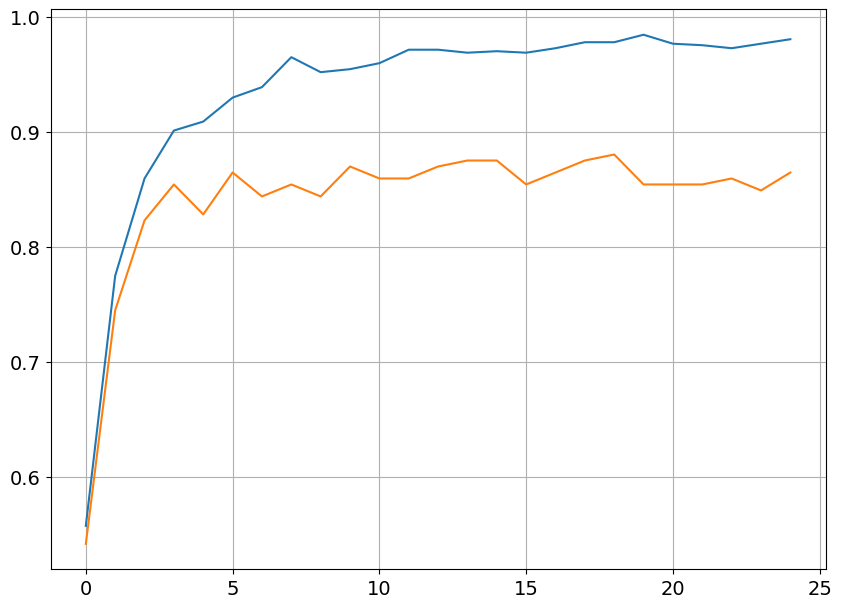

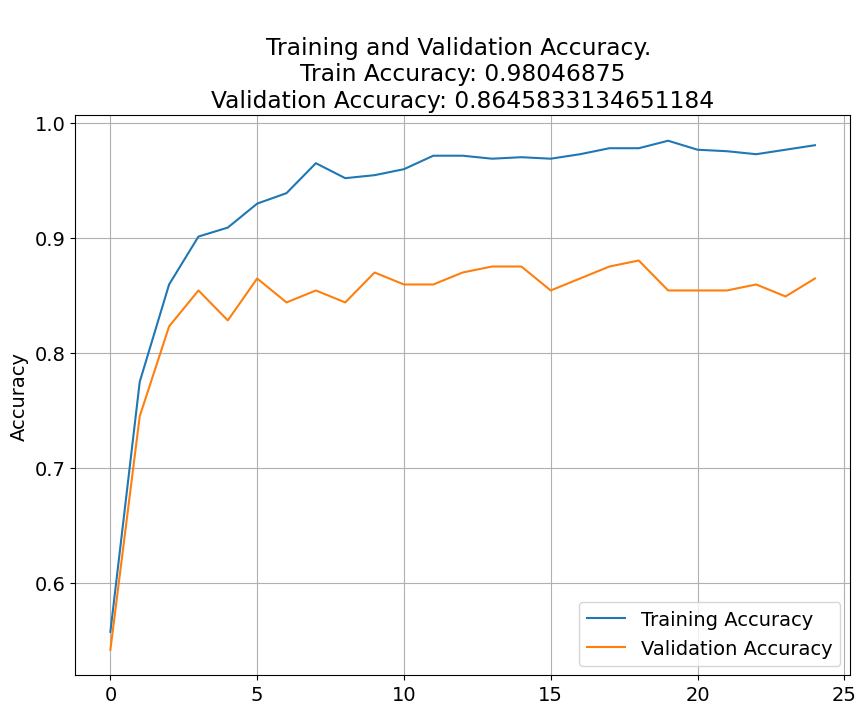

In [ ]:
# store results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# store results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

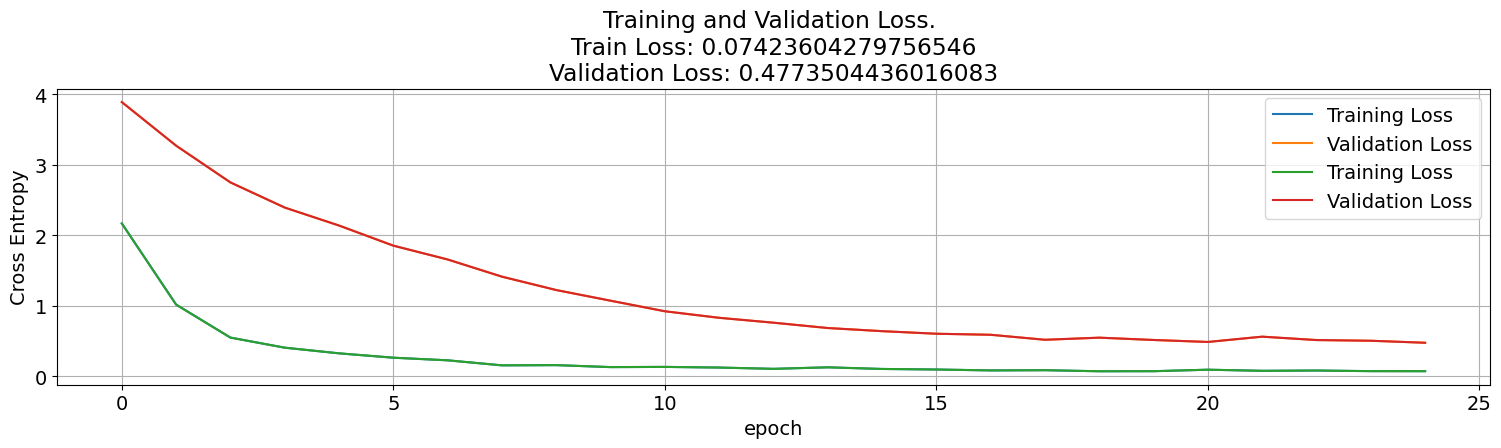

<Figure size 1600x900 with 0 Axes>

In [ ]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()


plt.tight_layout(pad=3.0)
plt.show()


In [ ]:
accuracy_score = model.evaluate(validation_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))

print("Loss: ",accuracy_score[0])


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 708ms/step - accuracy: 0.8763 - loss: 0.4765
[0.47662606835365295, 0.8697916865348816]
Accuracy: 86.9792%
Loss:  0.47662606835365295


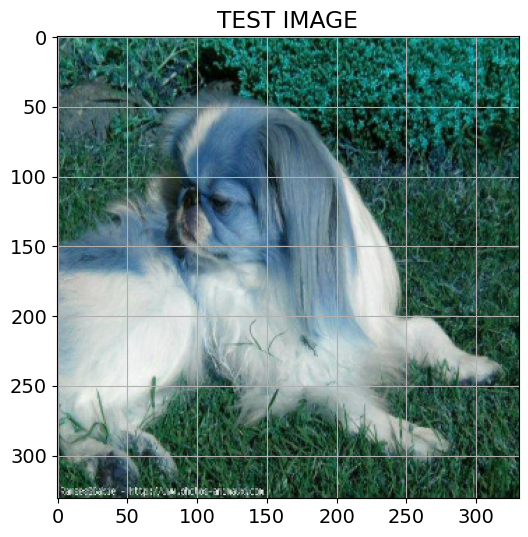

In [ ]:
test_img_path = test_path+"/000621fb3cbb32d8935728e48679680e.jpg"

img = cv2.imread(test_img_path)
resized_img = cv2.resize(img, (331, 331)).reshape(-1, 331, 331, 3)/255

plt.figure(figsize=(6,6))
plt.title("TEST IMAGE")
plt.imshow(resized_img[0])

In [ ]:
predictions = []

for image in sample.id:
    img = tf.keras.preprocessing.image.load_img(test_path +'/'+ image)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.preprocessing.image.smart_resize(img, (331, 331))
    img = tf.reshape(img, (-1, 331, 331, 3))
    prediction = model.predict(img/255)
    predictions.append(np.argmax(prediction))

my_submission = pd.DataFrame({'image_id': sample.id, 'label':  predictions})
my_submission.to_csv('submission.csv', index=False)

# Submission file output
print("Submission File: \n---------------\n")
print(my_submission.head()) # Displaying first five predicted output


NameError: name 'sample' is not defined